## Information on ** Bounded trajectory regression ** :

file : analyse/05_08_bounds/analyse_08_may.ipynb

This experimement is the main topic of my project. Given a maximal perturbation radius, we show that each coordinate of a predicted trajectory can be bounded. The theory behind this experiement is explained in the main readme.md. 

First the idea was to exactly implement the formullas. To implement (1), a monte carlo was used, with N=100 resampling, and with the function f being the s-lstm with d-pool module. To approximate the expectation, the mean over all the samples is taken, coordinate-wise<br>
The bounds u and l are suposed to be absolute (i.e. no output of the s-lstm could go beyond). As the trajectory prediction is a regression problem, no such bounds can exist. We decided to fix the same bounds for all coordinates of a scene. To choose their value, we would first generate the N predictions with the s-lstm, look at the 4 most extreme coordinates ($x_l, x_u, y_l, y_u$) and add a margin to each of them. This way, the bounds chosen should hold for the vast majority of any prediction, given a small perturbation on the observation.

![mean_smooth_regr](../../figures_readme/mean_smoothing_formulla.png)

Secondly, we wanted to experiment with other "expectation" functions. Instead of using the mean in the monte carlo resamplping, we tried two types of medians. Altough this would change the implication of the formulla, we wanted to see if the bounds were tighter.<br>
The median type 1 is the trajectory that has to smallest distance to all the other sampled trajectory. A benefit of median type 1 is that it is an existing trajectory, where mean or median type 2 are "crafted" trajectories not purely generated by the s-lstm model.<br>
The median type 2 is alike the mean, we just take the median of each coordinate separetelly.

Thirdly, I added diffusion noising and denoising to the pipeline. The diffusion denoiser has for goal to remoove a part of the noise added and make the trajectory "more plausible". Then, the expectation is again aproximate with the mean. <br>
The theory hold in this case, because we can rewrite   $\mathop{\mathbb{E}}[f\circ h_{denoise}(x+\epsilon)] = \mathop{\mathbb{E}}[f'(x+\epsilon)]$. As the noise <has to be added trought the diffusion process, a corespondance with sigma must be establish. This part is explain in the main readme.

A danger of using mean, mean with diffusion or median type 2, is that the trajectory resulting from the expectantion is not "real". In case of an unfortunate multimodality, the "mean" trajectory could not be feasible. This was not investigated further.

In the experiment, the parameter $r$ coresponds to the maximal $L_2$ norm of the perturbation $\delta$. The number reported, for each scene are : ade (average displacement error), fde (final displacement error), abd (average box dimension) and fbd (final box dimension). The fbd/abd are metrics designed to evaluate how tight the bounds on each coordinates are. In the explample below, $fde = \frac{w_3 + h_3}{2}$ and $ade = \frac{\sum_{i=1}^3 w_i + h_i}{2*3}$, averaged across all agents.
<p align="center">
    <img src="../../figures_readme/abd_fbd.png"  width="600">
</p>

Complementary informations are given under each section below, and the plots are explained.


### Code : 

To generate those data, the files *bounded_regression\bound_predictor.py* and *bounded_regression\bound_model.py* were used. To run the code, a bash script named *run_bounds_smoothing.bat* can be launched (on windows). In this file the flag --function can be chosen between "mean", "median1", "median2" and "diffusion" to change the function used to "summarize" the random noisy trajectories.

To train the diffusion model, the file *diffusion_bound_regression/MID_from_git/main.py* is called, and it uses the whole librairy in *diffusion_bound_regression/MID_from_git*. The .bat script *run_diff_training.bat* is provided to begin the training. <br>
Two .yaml file, *diffusion_bound_regression\MID_from_git\configs\my_config.yaml* and *diffusion_bound_regression\MID_from_git\configs\my_config_eval.yaml*, contains the parameters. One must specify at which epochs one wants to save a checkpoint of the model (*eval_every*), and the model from which epoch oe wants to use for testing (*eval_at*). The trained model is automatically saved in the *diffusion_bound_regression\MID_from_git\experiments\my_config* folder, and must be moved into the *diffusion_bound_regression\MID_from_git\experiments\my_config_eval* folder.

In [20]:
import pandas as pd
import matplotlib.pyplot as plt

# with mean

Data were generate over the whole test dataset (private with the ground truth here). In total, I generated 9 data while changing the hyperparameters. All combinaison of $r = 1, 5, 10$ cm and $\sigma = 5, 10, 50$ cm were used. Then, the metrics are averaged over all the 3146 scenes.

In [21]:
df_r_001_s_005 = pd.read_csv("data/mean/temp_sig0.05_r0.01.txt", sep="\t")
df_r_001_s_01 = pd.read_csv("data/mean/temp_sig0.1_r0.01.txt", sep="\t")
df_r_001_s_05 = pd.read_csv("data/mean/temp_sig0.5_r0.01.txt", sep="\t")

df_r_005_s_005 = pd.read_csv("data/mean/temp_sig0.05_r0.05.txt", sep="\t")
df_r_005_s_01_mean = pd.read_csv("data/mean/temp_sig0.1_r0.05.txt", sep="\t")
df_r_005_s_05 = pd.read_csv("data/mean/temp_sig0.5_r0.05.txt", sep="\t")

df_r_01_s_005 = pd.read_csv("data/mean/temp_sig0.05_r0.1.txt", sep="\t")
df_r_01_s_01 = pd.read_csv("data/mean/temp_sig0.1_r0.1.txt", sep="\t")
df_r_01_s_05 = pd.read_csv("data/mean/temp_sig0.5_r0.1.txt", sep="\t")

df_all_mean = pd.concat((df_r_001_s_005, df_r_001_s_01, df_r_001_s_05, 
                    df_r_005_s_005, df_r_005_s_01_mean, df_r_005_s_05,
                    df_r_01_s_005, df_r_01_s_01, df_r_01_s_05), ignore_index=True)

In [22]:
df_mean_mean = df_all_mean.groupby(["r", "sigma"], as_index=False).mean()

In [23]:
df_mean_mean

,r,sigma,scene_id,ade,fde,abd,fbd
0,0.01,0.05,710.017165,0.561490,1.196024,2.283751,2.117378
1,0.01,0.10,710.017165,0.594069,1.246066,1.172176,1.090146
2,0.01,0.50,710.017165,0.839427,1.620344,0.274974,0.260446
3,0.05,0.05,710.017165,0.561329,1.194686,10.140477,9.580723
4,0.05,0.10,710.017165,0.593372,1.244276,5.686684,5.315468
5,0.05,0.50,710.017165,0.841076,1.622002,1.375492,1.303030
6,0.10,0.05,710.017165,0.560539,1.194769,14.988954,14.667803
7,0.10,0.10,710.017165,0.594628,1.246115,10.363546,9.819495
8,0.10,0.50,710.017165,0.845402,1.628395,2.737443,2.594348


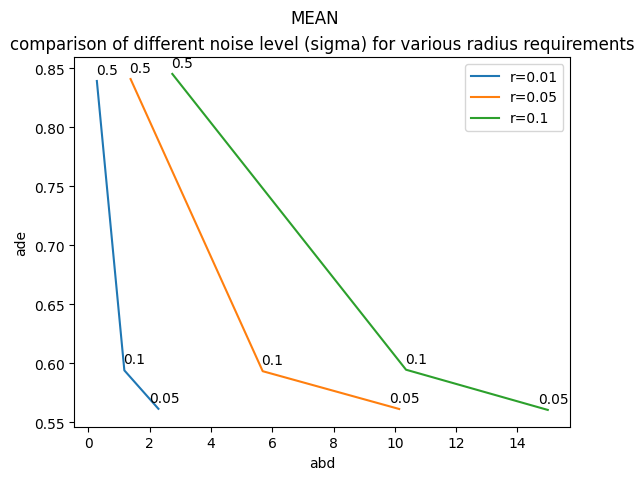

In [24]:
fig, ax = plt.subplots()
df_mean_mean
[ax.plot(df_mean_mean[df_mean_mean["r"] == r]["abd"], df_mean_mean[df_mean_mean["r"] == r]["ade"], label = f"r={r}") for r in [0.01, 0.05, 0.10]]
ax.set(title="comparison of different noise level (sigma) for various radius requirements", xlabel="abd", ylabel="ade")
plt.legend()
plt.suptitle("MEAN")

for r in [0.01, 0.05, 0.10]:
    for i, (x,y) in enumerate(zip(df_mean_mean[df_mean_mean["r"] == r]["abd"],df_mean_mean[df_mean_mean["r"] == r]["ade"])):

        label = str(df_mean_mean.iloc[i]["sigma"])

        plt.annotate(label, # this is the text
                    (x,y), # these are the coordinates to position the label
                    textcoords="offset points", # how to position the text
                    xytext=(15,5), # distance from text to points (x,y)
                    ha='right')

For each different maximal perturbation radius $r$ (different line color), 3 values of noise standard deviation $\sigma$ were tested. The noise level is specified above the point. On this plot, the ade and abd are reported on the axis for each combinaison of parameters. The mean was use to approximate the expectation.

We see that for a bigger noise level, the adb is better, but the ade gets worse. <br>
Also, for values of $\sigma \lessapprox 10*r$, we see that the box dimensions gets really large.

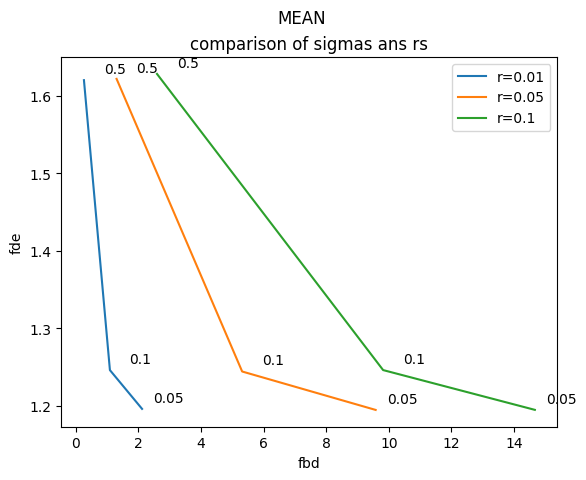

In [25]:
fig, ax = plt.subplots()
[ax.plot(df_mean_mean[df_mean_mean["r"] == r]["fbd"], df_mean_mean[df_mean_mean["r"] == r]["fde"], label = f"r={r}") for r in [0.01, 0.05, 0.10]]
ax.set(title="comparison of sigmas ans rs", xlabel="fbd", ylabel="fde")
plt.legend()
plt.suptitle("MEAN")

for r in [0.01, 0.05, 0.10]:
    for i, (x,y) in enumerate(zip(df_mean_mean[df_mean_mean["r"] == r]["fbd"],df_mean_mean[df_mean_mean["r"] == r]["fde"])):

        label = str(df_mean_mean.iloc[i]["sigma"])

        plt.annotate(label, # this is the text
                    (x,y), # these are the coordinates to position the label
                    textcoords="offset points", # how to position the text
                    xytext=(30,5), # distance from text to points (x,y)
                    ha='right')

This plot is alike the other, but showcasing the fde and fbd on the axis.

# with median 1

Data were generate over the whole test dataset (private with the ground truth here). In total, I generated 9 data while changing the hyperparameters. All combinaison of $r = 1, 5, 10$ cm and $\sigma = 5, 10, 50$ cm were used. Then, the metrics are averaged over all the 3146 scenes.

In [26]:
df_r_001_s_005 = pd.read_csv("data/med1/temp_sig0.05_r0.01.txt", sep="\t")
df_r_001_s_01 = pd.read_csv("data/med1/temp_sig0.1_r0.01.txt", sep="\t")
df_r_001_s_05 = pd.read_csv("data/med1/temp_sig0.5_r0.01.txt", sep="\t")

df_r_005_s_005 = pd.read_csv("data/med1/temp_sig0.05_r0.05.txt", sep="\t")
df_r_005_s_01 = pd.read_csv("data/med1/temp_sig0.1_r0.05.txt", sep="\t")
df_r_005_s_05 = pd.read_csv("data/med1/temp_sig0.5_r0.05.txt", sep="\t")

df_r_01_s_005 = pd.read_csv("data/med1/temp_sig0.05_r0.1.txt", sep="\t")
df_r_01_s_01 = pd.read_csv("data/med1/temp_sig0.1_r0.1.txt", sep="\t")
df_r_01_s_05 = pd.read_csv("data/med1/temp_sig0.5_r0.1.txt", sep="\t")

df_all_med1 = pd.concat((df_r_001_s_005, df_r_001_s_01, df_r_001_s_05, 
                    df_r_005_s_005, df_r_005_s_01, df_r_005_s_05,
                    df_r_01_s_005, df_r_01_s_01, df_r_01_s_05), ignore_index=True)

In [27]:
df_med1_mean = df_all_med1.groupby(["r", "sigma"], as_index=False).mean()

In [28]:
df_med1_mean

,r,sigma,scene_id,ade,fde,abd,fbd
0,0.01,0.05,710.017165,0.568305,1.198737,2.283699,2.117184
1,0.01,0.10,710.017165,0.605967,1.252051,1.172167,1.090048
2,0.01,0.50,710.017165,0.880531,1.590744,0.274961,0.260382
3,0.05,0.05,710.017165,0.567788,1.196975,10.140213,9.580026
4,0.05,0.10,710.017165,0.606395,1.251170,5.686633,5.314972
5,0.05,0.50,710.017165,0.888437,1.597930,1.375432,1.302711
6,0.10,0.05,710.017165,0.568541,1.199886,14.988898,14.667498
7,0.10,0.10,710.017165,0.607478,1.251299,10.363377,9.818592
8,0.10,0.50,710.017165,0.887665,1.593811,2.737342,2.593831


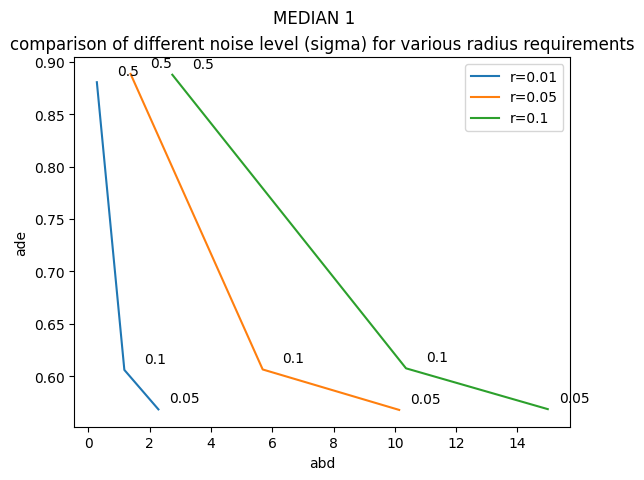

In [29]:
fig, ax = plt.subplots()

[ax.plot(df_med1_mean[df_med1_mean["r"] == r]["abd"], df_med1_mean[df_med1_mean["r"] == r]["ade"], label = f"r={r}") for r in [0.01, 0.05, 0.10]]
ax.set(title="comparison of different noise level (sigma) for various radius requirements", xlabel="abd", ylabel="ade")
plt.suptitle("MEDIAN 1")
plt.legend()

for r in [0.01, 0.05, 0.10]:
    for i, (x,y) in enumerate(zip(df_med1_mean[df_med1_mean["r"] == r]["abd"],df_med1_mean[df_med1_mean["r"] == r]["ade"])):

        label = str(df_med1_mean.iloc[i]["sigma"])

        plt.annotate(label, # this is the text
                    (x,y), # these are the coordinates to position the label
                    textcoords="offset points", # how to position the text
                    xytext=(30,5), # distance from text to points (x,y)
                    ha='right')

This plot is very similar to the previous.

For each different maximal perturbation radius $r$ (different line color), 3 values of noise standard deviation $\sigma$ were tested. The noise level is specified above the point. On this plot, the ade and abd are reported on the axis for each combinaison of parameters. The median of type 1 was use to approximate the expectation.

We see that for a bigger noise level, the adb is better, but the ade gets worse. <br>
Also, for values of $\sigma \lessapprox 10*r$, we see that the box dimensions gets really large.

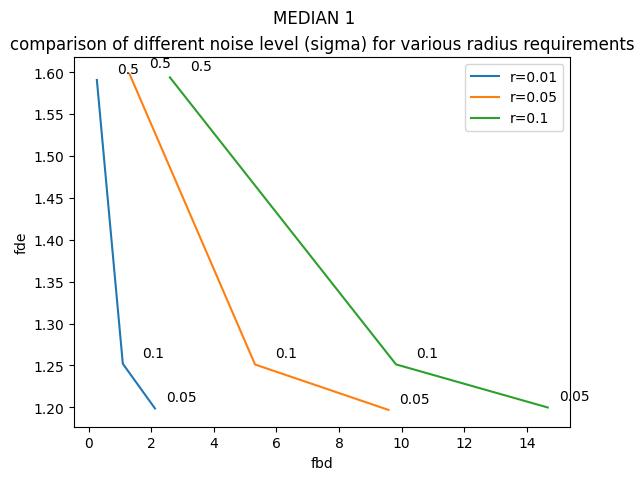

In [30]:
fig, ax = plt.subplots()

[ax.plot(df_med1_mean[df_med1_mean["r"] == r]["fbd"], df_med1_mean[df_med1_mean["r"] == r]["fde"], label = f"r={r}") for r in [0.01, 0.05, 0.10]]
ax.set(title="comparison of different noise level (sigma) for various radius requirements", xlabel="fbd", ylabel="fde")
plt.suptitle("MEDIAN 1")
plt.legend()

for r in [0.01, 0.05, 0.10]:
    for i, (x,y) in enumerate(zip(df_med1_mean[df_med1_mean["r"] == r]["fbd"],df_med1_mean[df_med1_mean["r"] == r]["fde"])):

        label = str(df_med1_mean.iloc[i]["sigma"])

        plt.annotate(label, # this is the text
                    (x,y), # these are the coordinates to position the label
                    textcoords="offset points", # how to position the text
                    xytext=(30,5), # distance from text to points (x,y)
                    ha='right')

This plot is alike the other, but showcasing the fde and fbd on the axis.

## With median 2

Data were generate over the whole test dataset (private with the ground truth here). In total, I generated 9 data while changing the hyperparameters. All combinaison of $r = 1, 5, 10$ cm and $\sigma = 5, 10, 50$ cm were used. Then, the metrics are averaged over all the 3146 scenes.

In [31]:
df_r_001_s_005 = pd.read_csv("data/med2/temp_sig0.05_r0.01.txt", sep="\t")
df_r_001_s_01 = pd.read_csv("data/med2/temp_sig0.1_r0.01.txt", sep="\t")
df_r_001_s_05 = pd.read_csv("data/med2/temp_sig0.5_r0.01.txt", sep="\t")

df_r_005_s_005 = pd.read_csv("data/med2/temp_sig0.05_r0.05.txt", sep="\t")
df_r_005_s_01 = pd.read_csv("data/med2/temp_sig0.1_r0.05.txt", sep="\t")
df_r_005_s_05 = pd.read_csv("data/med2/temp_sig0.5_r0.05.txt", sep="\t")

df_r_01_s_005 = pd.read_csv("data/med2/temp_sig0.05_r0.1.txt", sep="\t")
df_r_01_s_01 = pd.read_csv("data/med2/temp_sig0.1_r0.1.txt", sep="\t")
df_r_01_s_05 = pd.read_csv("data/med2/temp_sig0.5_r0.1.txt", sep="\t")

df_all_med2 = pd.concat((df_r_001_s_005, df_r_001_s_01, df_r_001_s_05, 
                    df_r_005_s_005, df_r_005_s_01, df_r_005_s_05,
                    df_r_01_s_005, df_r_01_s_01, df_r_01_s_05), ignore_index=True)

In [32]:
df_med2_mean = df_all_med2.groupby(["r", "sigma"], as_index=False).mean()

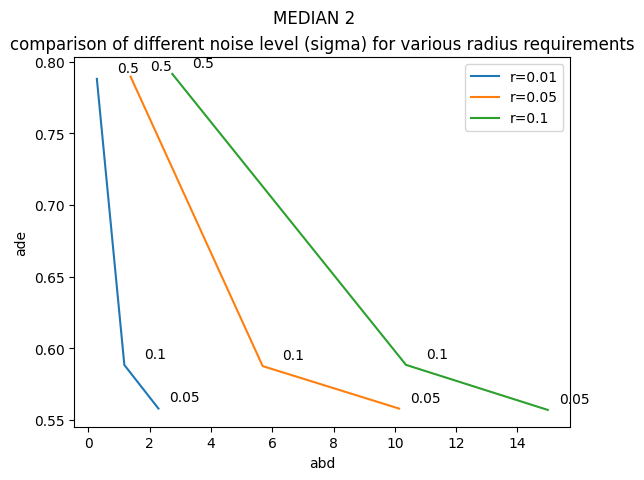

In [33]:
fig, ax = plt.subplots()

[ax.plot(df_med2_mean[df_med2_mean["r"] == r]["abd"], df_med2_mean[df_med2_mean["r"] == r]["ade"], label = f"r={r}") for r in [0.01, 0.05, 0.10]]
ax.set(title="comparison of different noise level (sigma) for various radius requirements", xlabel="abd", ylabel="ade")
plt.suptitle("MEDIAN 2")
plt.legend()

for r in [0.01, 0.05, 0.10]:
    for i, (x,y) in enumerate(zip(df_med2_mean[df_med2_mean["r"] == r]["abd"],df_med2_mean[df_med2_mean["r"] == r]["ade"])):

        label = str(df_med2_mean.iloc[i]["sigma"])

        plt.annotate(label, # this is the text
                    (x,y), # these are the coordinates to position the label
                    textcoords="offset points", # how to position the text
                    xytext=(30,5), # distance from text to points (x,y)
                    ha='right')

This plot is very similar to the previous.

For each different maximal perturbation radius $r$ (different line color), 3 values of noise standard deviation $\sigma$ were tested. The noise level is specified above the point. On this plot, the ade and abd are reported on the axis for each combinaison of parameters. The median of type 2 was use to approximate the expectation.

We see that for a bigger noise level, the adb is better, but the ade gets worse. <br>
Also, for values of $\sigma \lessapprox 10*r$, we see that the box dimensions gets really large.

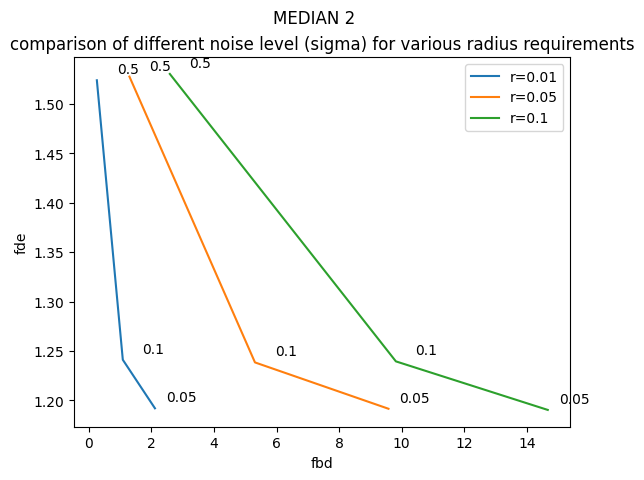

In [34]:
fig, ax = plt.subplots()

[ax.plot(df_med2_mean[df_med2_mean["r"] == r]["fbd"], df_med2_mean[df_med2_mean["r"] == r]["fde"], label = f"r={r}") for r in [0.01, 0.05, 0.10]]
ax.set(title="comparison of different noise level (sigma) for various radius requirements", xlabel="fbd", ylabel="fde")
plt.suptitle("MEDIAN 2")
plt.legend()

for r in [0.01, 0.05, 0.10]:
    for i, (x,y) in enumerate(zip(df_med2_mean[df_med2_mean["r"] == r]["fbd"],df_med2_mean[df_med2_mean["r"] == r]["fde"])):

        label = str(df_med2_mean.iloc[i]["sigma"])

        plt.annotate(label, # this is the text
                    (x,y), # these are the coordinates to position the label
                    textcoords="offset points", # how to position the text
                    xytext=(30,5), # distance from text to points (x,y)
                    ha='right')

This plot is alike the other, but showcasing the fde and fbd on the axis.

# With diffusion

more data ??

Data were generate over the whole test dataset (private with the ground truth here). In total, I generated 9 data while changing the hyperparameters. All combinaison of $r = 1, 5, 10$ cm and $\sigma = 5, 10, 50$ cm were used. Then, the metrics are averaged over all the 3146 scenes.

In [35]:
df_r_001_s_005 = pd.read_csv("data/diff/temp_sig0.05_r0.01.txt", sep="\t")
df_r_001_s_01 = pd.read_csv("data/diff/temp_sig0.1_r0.01.txt", sep="\t")
df_r_001_s_023 = pd.read_csv("data/diff/temp_sig0.23_r0.01.txt", sep="\t")

df_r_005_s_005 = pd.read_csv("data/diff/temp_sig0.05_r0.05.txt", sep="\t")
df_r_005_s_01_diff = pd.read_csv("data/diff/temp_sig0.1_r0.05.txt", sep="\t")
df_r_005_s_023 = pd.read_csv("data/diff/temp_sig0.23_r0.05.txt", sep="\t")



df_all_diff = pd.concat((df_r_001_s_005, df_r_001_s_01, df_r_001_s_023,
                         df_r_005_s_005, df_r_005_s_01_diff, df_r_005_s_023), ignore_index=True)

In [36]:
df_diff_mean = df_all_diff.groupby(["r", "sigma"], as_index=False).mean()
df_diff_mean

,r,sigma,scene_id,ade,fde,abd,fbd
0,0.01,0.05,710.017165,0.563574,1.177173,2.360178,2.192059
1,0.01,0.10,710.017165,0.564554,1.172293,1.220236,1.137002
2,0.01,0.23,710.017165,1.075127,1.636681,0.617465,0.584501
3,0.05,0.05,710.017165,0.563977,1.179823,10.474385,9.910253
4,0.05,0.10,710.017165,0.564890,1.173558,5.907205,5.529926
5,0.05,0.23,40.834677,0.946098,1.413582,2.911463,2.749472


# With diffusion - WRONG

In [37]:
df_r_001_s_005 = pd.read_csv("data/diff_wrong/temp_sig0.05_r0.01.txt", sep="\t")
df_r_001_s_01 = pd.read_csv("data/diff_wrong/temp_sig0.1_r0.01.txt", sep="\t")
df_r_001_s_023 = pd.read_csv("data/diff_wrong/temp_sig0.23_r0.01.txt", sep="\t")

df_r_005_s_005 = pd.read_csv("data/diff_wrong/temp_sig0.05_r0.05.txt", sep="\t")
df_r_005_s_01_diff = pd.read_csv("data/diff_wrong/temp_sig0.1_r0.05.txt", sep="\t")
df_r_005_s_023 = pd.read_csv("data/diff_wrong/temp_sig0.23_r0.05.txt", sep="\t")

df_r_01_s_005 = pd.read_csv("data/diff_wrong/temp_sig0.05_r0.1.txt", sep="\t")
df_r_01_s_01 = pd.read_csv("data/diff_wrong/temp_sig0.1_r0.1.txt", sep="\t")
df_r_01_s_023 = pd.read_csv("data/diff_wrong/temp_sig0.23_r0.1.txt", sep="\t")

df_all_diff_w = pd.concat((df_r_001_s_005, df_r_001_s_01, df_r_001_s_023, 
                    df_r_005_s_005, df_r_005_s_01_diff, df_r_005_s_023,
                    df_r_01_s_005, df_r_01_s_01, df_r_01_s_023), ignore_index=True)

In [38]:
df_diff_mean_w = df_all_diff_w.groupby(["r", "sigma"], as_index=False).mean()
df_diff_mean_w

,r,sigma,scene_id,ade,fde,abd,fbd
0,0.01,0.05,710.017165,0.566224,1.177270,2.782684,2.649205
1,0.01,0.10,710.017165,0.567810,1.170591,1.523920,1.459346
2,0.01,0.23,710.017165,1.189329,1.880357,0.930050,0.898776
3,0.05,0.05,710.017165,0.567843,1.180484,12.265432,11.826237
4,0.05,0.10,710.017165,0.567784,1.173106,7.367552,7.077401
5,0.05,0.23,710.017165,1.189894,1.882025,4.616671,4.463344
6,0.10,0.05,710.017165,0.567157,1.179767,17.845646,17.608512
7,0.10,0.10,710.017165,0.567495,1.170812,13.346343,12.929021
8,0.10,0.23,710.017165,1.192158,1.885334,9.038801,8.750409


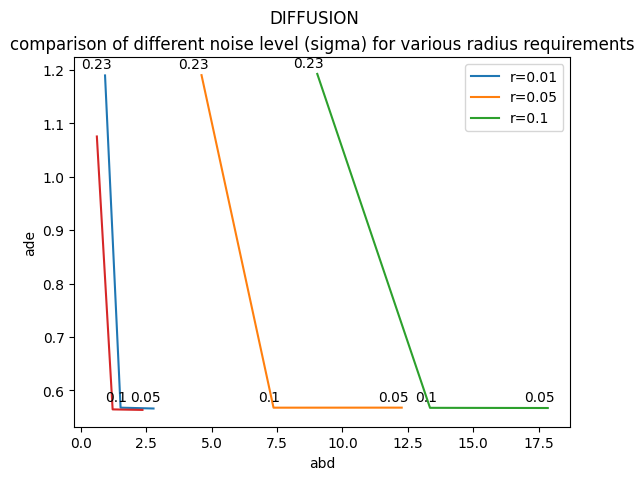

In [39]:
fig, ax = plt.subplots()

[ax.plot(df_diff_mean_w[df_diff_mean_w["r"] == r]["abd"], df_diff_mean_w[df_diff_mean_w["r"] == r]["ade"], label = f"r={r}") for r in [0.01, 0.05, 0.10]]
ax.set(title="comparison of different noise level (sigma) for various radius requirements", xlabel="abd", ylabel="ade")
plt.suptitle("DIFFUSION")
plt.legend()

[ax.plot(df_diff_mean[df_diff_mean["r"] == r]["abd"], df_diff_mean[df_diff_mean["r"] == r]["ade"], label = f"r={r}") for r in [0.01]]


for r in [0.01, 0.05, 0.10]:
    for i, (x,y) in enumerate(zip(df_diff_mean_w[df_diff_mean_w["r"] == r]["abd"],df_diff_mean_w[df_diff_mean_w["r"] == r]["ade"])):

        label = str(df_diff_mean_w.iloc[i]["sigma"])

        plt.annotate(label, # this is the text
                    (x,y), # these are the coordinates to position the label
                    textcoords="offset points", # how to position the text
                    xytext=(5,5), # distance from text to points (x,y)
                    ha='right')

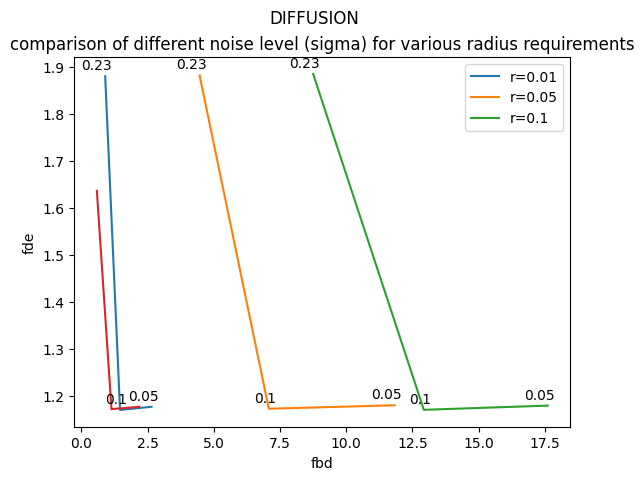

In [40]:
fig, ax = plt.subplots()

[ax.plot(df_diff_mean_w[df_diff_mean_w["r"] == r]["fbd"], df_diff_mean_w[df_diff_mean_w["r"] == r]["fde"], label = f"r={r}") for r in [0.01, 0.05, 0.10]]
ax.set(title="comparison of different noise level (sigma) for various radius requirements", xlabel="fbd", ylabel="fde")
plt.suptitle("DIFFUSION")
plt.legend()

[ax.plot(df_diff_mean[df_diff_mean["r"] == r]["fbd"], df_diff_mean[df_diff_mean["r"] == r]["fde"], label = f"r={r}") for r in [0.01]]

for r in [0.01, 0.05, 0.10]:
    for i, (x,y) in enumerate(zip(df_diff_mean_w[df_diff_mean_w["r"] == r]["fbd"],df_diff_mean_w[df_diff_mean_w["r"] == r]["fde"])):

        label = str(df_diff_mean_w.iloc[i]["sigma"])

        plt.annotate(label, # this is the text
                    (x,y), # these are the coordinates to position the label
                    textcoords="offset points", # how to position the text
                    xytext=(5,5), # distance from text to points (x,y)
                    ha='right')

# mean vs med1 vs med2 vs diffusion for fix r

recall : 

mean : take the mean for all agent, all timestep, all dimension of the N (=100) noisy predictions generated -> the resulting trajectory is thus not necessarly one generated by the noisy predictions.

median1 : among the N (=100) noisy predictions generated, take the one with the smallest distance with respect to all the other.

median2 : take the median for all agent, all timestep, all dimension of the N (=100) noisy samples generated. -> the resulting trajectory is thus not necessarly one generated by the noisy predictions. 

diffusion : apply a diffusion denoiser model (trained to generate trajs data) after the noising step. Then, Expectancy is computed with the mean

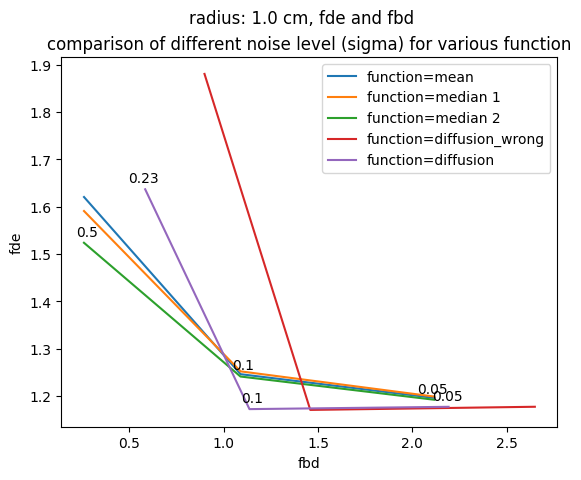

In [41]:
fig, ax = plt.subplots()
r = 0.01 # 1 cm
func_name = ["mean", "median 1", "median 2", "diffusion_wrong","diffusion"]
[ax.plot(df[df["r"] == r]["fbd"], df[df["r"] == r]["fde"], label = f"function={func_name[i]}") for i, df in enumerate([df_mean_mean, df_med1_mean, df_med2_mean, df_diff_mean_w, df_diff_mean])]
ax.set(title="comparison of different noise level (sigma) for various function", xlabel="fbd", ylabel="fde")
plt.suptitle(f"radius: {r*100} cm, fde and fbd")
for df in (df_med2_mean, df_diff_mean):
        for i, (x,y) in enumerate(zip(df[df["r"] == r]["fbd"],df[df["r"] == r]["fde"])):

                label = str(df.iloc[i]["sigma"])

                plt.annotate(label, # this is the text
                        (x,y), # these are the coordinates to position the label
                        textcoords="offset points", # how to position the text
                        xytext=(10,5), # distance from text to points (x,y)
                        ha='right')

plt.legend()

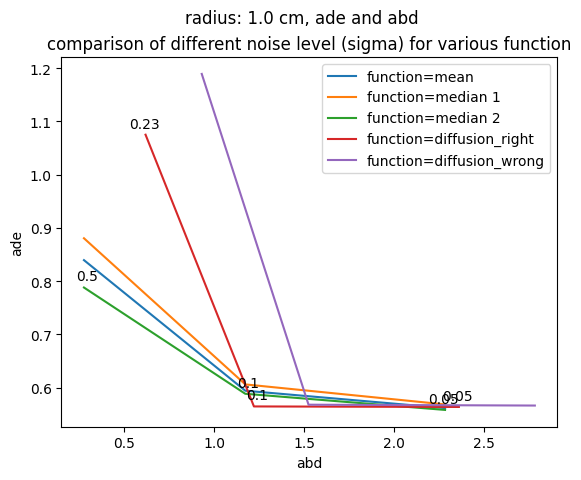

In [42]:
fig, ax = plt.subplots()
r = 0.01 # 1 cm
func_name = ["mean", "median 1", "median 2", "diffusion_right", "diffusion_wrong"]
[ax.plot(df[df["r"] == r]["abd"], df[df["r"] == r]["ade"], label = f"function={func_name[i]}") for i, df in enumerate([df_mean_mean, df_med1_mean, df_med2_mean, df_diff_mean, df_diff_mean_w])]
ax.set(title="comparison of different noise level (sigma) for various function", xlabel="abd", ylabel="ade")
plt.suptitle(f"radius: {r*100} cm, ade and abd")
for df in (df_med2_mean, df_diff_mean):
        for i, (x,y) in enumerate(zip(df[df["r"] == r]["abd"],df[df["r"] == r]["ade"])):

                label = str(df.iloc[i]["sigma"])

                plt.annotate(label, # this is the text
                        (x,y), # these are the coordinates to position the label
                        textcoords="offset points", # how to position the text
                        xytext=(10,5), # distance from text to points (x,y)
                        ha='right')

plt.legend()

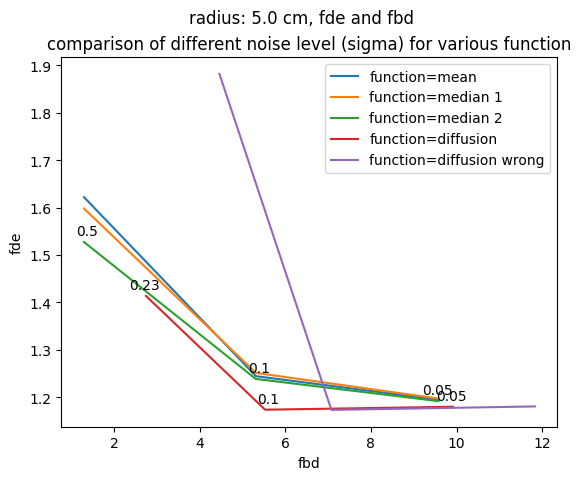

In [43]:
fig, ax = plt.subplots()
r = 0.05 # 5 cm
func_name = ["mean", "median 1", "median 2", "diffusion", "diffusion wrong"]
[ax.plot(df[df["r"] == r]["fbd"], df[df["r"] == r]["fde"], label = f"function={func_name[i]}") for i, df in enumerate([df_mean_mean, df_med1_mean, df_med2_mean, df_diff_mean, df_diff_mean_w])]
ax.set(title="comparison of different noise level (sigma) for various function", xlabel="fbd", ylabel="fde")
plt.suptitle(f"radius: {r*100} cm, fde and fbd")
for df in (df_med2_mean, df_diff_mean):
        for i, (x,y) in enumerate(zip(df[df["r"] == r]["fbd"],df[df["r"] == r]["fde"])):

                label = str(df.iloc[i]["sigma"])

                plt.annotate(label, # this is the text
                        (x,y), # these are the coordinates to position the label
                        textcoords="offset points", # how to position the text
                        xytext=(10,5), # distance from text to points (x,y)
                        ha='right')

plt.legend()

big change : the final/average box dimensions are much bigger 

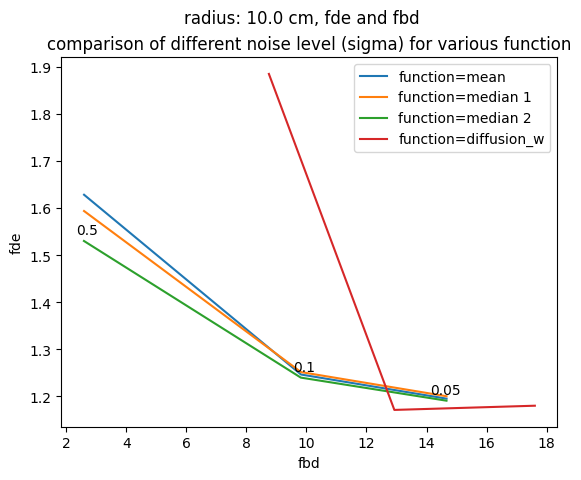

In [44]:
fig, ax = plt.subplots()
r = 0.1 # 10 cm
func_name = ["mean", "median 1", "median 2", "diffusion_w"]
[ax.plot(df[df["r"] == r]["fbd"], df[df["r"] == r]["fde"], label = f"function={func_name[i]}") for i, df in enumerate([df_mean_mean, df_med1_mean, df_med2_mean, df_diff_mean_w])]
ax.set(title="comparison of different noise level (sigma) for various function", xlabel="fbd", ylabel="fde")
plt.suptitle(f"radius: {r*100} cm, fde and fbd")
for df in (df_med2_mean, df_diff_mean):
        for i, (x,y) in enumerate(zip(df[df["r"] == r]["fbd"],df[df["r"] == r]["fde"])):

                label = str(df.iloc[i]["sigma"])

                plt.annotate(label, # this is the text
                        (x,y), # these are the coordinates to position the label
                        textcoords="offset points", # how to position the text
                        xytext=(10,5), # distance from text to points (x,y)
                        ha='right')

plt.legend()

# focus diff vs mean r= 5cm

In [53]:
df_r_005_s_005 = pd.read_csv("data/diff/temp_sig0.05_r0.05.txt", sep="\t")
df_r_005_s_0075 = pd.read_csv("data/diff/temp_sig0.075_r0.05.txt", sep="\t")
df_r_005_s_01_diff = pd.read_csv("data/diff/temp_sig0.1_r0.05.txt", sep="\t")
df_r_005_s_023 = pd.read_csv("data/diff/temp_sig0.23_r0.05.txt", sep="\t")

df_all_diff = pd.concat((df_r_005_s_005, df_r_005_s_0075, df_r_005_s_01_diff, df_r_005_s_023), ignore_index=True)

df_diff_mean = df_all_diff.groupby(["r", "sigma"], as_index=False).mean()

In [54]:
#mean
df_r_005_s_005 = pd.read_csv("data/mean/temp_sig0.05_r0.05.txt", sep="\t")
df_r_005_s_0075 = pd.read_csv("data/mean/temp_sig0.075_r0.05.txt", sep="\t")
df_r_005_s_01 = pd.read_csv("data/mean/temp_sig0.1_r0.05.txt", sep="\t")
df_r_005_s_0125 = pd.read_csv("data/mean/temp_sig0.125_r0.05.txt", sep="\t")


df_all_mean = pd.concat((df_r_005_s_005, df_r_005_s_0075, df_r_005_s_01_mean, df_r_005_s_0125), ignore_index=True)

df_mean_mean = df_all_mean.groupby(["r", "sigma"], as_index=False).mean()


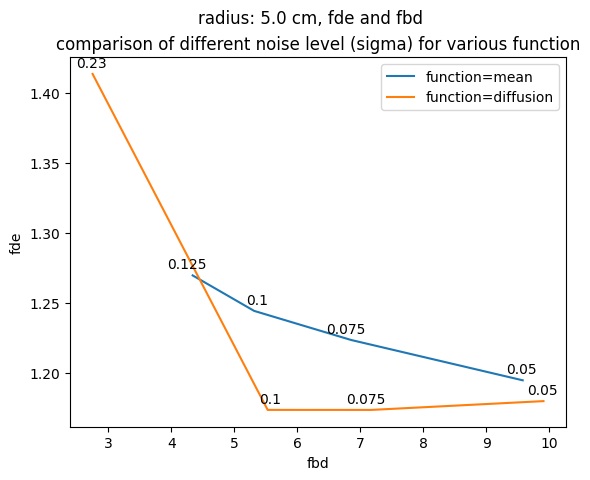

In [56]:
fig, ax = plt.subplots()
r = 0.05 # 1 cm
func_name = ["mean","diffusion"]
[ax.plot(df[df["r"] == r]["fbd"], df[df["r"] == r]["fde"], label = f"function={func_name[i]}") for i, df in enumerate([df_mean_mean, df_diff_mean])]
ax.set(title="comparison of different noise level (sigma) for various function", xlabel="fbd", ylabel="fde")
plt.suptitle(f"radius: {r*100} cm, fde and fbd")
for df in (df_mean_mean, df_diff_mean):
        for i, (x,y) in enumerate(zip(df[df["r"] == r]["fbd"],df[df["r"] == r]["fde"])):

                label = str(df.iloc[i]["sigma"])

                plt.annotate(label, # this is the text
                        (x,y), # these are the coordinates to position the label
                        textcoords="offset points", # how to position the text
                        xytext=(10,5), # distance from text to points (x,y)
                        ha='right')

plt.legend()